In [1]:
# !pip list

In [2]:
import tensorflow as tf

import os

In [3]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Importing Dataset from Kaggle


In [6]:
# calling kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory


In [7]:
! kaggle datasets download -d jehanbhathena/weather-dataset

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0
100% 587M/587M [00:27<00:00, 24.1MB/s]
100% 587M/587M [00:27<00:00, 22.6MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile("weather-dataset.zip", 'r')
zip_ref.extractall('/content')
zip_ref.close()

1. **We have 11 Different classes of weather**
2. **No Train or Test or validation data separation is here.**
   



# 2. Removing Dodgy Images

In [9]:
import cv2
import imghdr

In [10]:
data_dir = 'dataset'

In [11]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

**Checking the number of images present**

In [12]:
i = 0

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        i = i + 1
    print(image_class ,'has', i,'images')

sandstorm has 692 images
snow has 1313 images
rain has 1839 images
glaze has 2478 images
fogsmog has 3329 images
lightning has 3706 images
dew has 4404 images
rime has 5564 images
rainbow has 5796 images
frost has 6271 images
hail has 6862 images


**Checking if there is any file in unwanted format**

In [13]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Image not in ext list dataset/sandstorm/3191.jpg
Image not in ext list dataset/sandstorm/3222.jpg
Image not in ext list dataset/sandstorm/3249.jpg
Image not in ext list dataset/sandstorm/3212.jpg
Image not in ext list dataset/sandstorm/3278.jpg
Image not in ext list dataset/sandstorm/3488.jpg
Image not in ext list dataset/sandstorm/3468.jpg
Image not in ext list dataset/snow/1236.jpg
Image not in ext list dataset/snow/1401.jpg
Image not in ext list dataset/snow/1283.jpg
Image not in ext list dataset/snow/1334.jpg
Image not in ext list dataset/snow/1206.jpg
Image not in ext list dataset/snow/1439.jpg
Image not in ext list dataset/snow/0835.jpg
Image not in ext list dataset/snow/1366.jpg
Image not in ext list dataset/snow/1394.jpg
Image not in ext list dataset/snow/1282.jpg
Image not in ext list dataset/snow/1069.jpg
Image not in ext list dataset/snow/1437.jpg
Image not in ext list dataset/snow/1315.jpg
Image not in ext list dataset/snow/1249.jpg
Image not in ext list dataset/snow/1267.j

# 3. Loading data in pipeline

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data = tf.keras.utils.image_dataset_from_directory('dataset')

# building a data pipeline to access image
# takes care of "input size"
#it do a ton of work behind the scene
# it shuffles the batch by default

Found 6768 files belonging to 11 classes.


In [16]:
data_iterator = data.as_numpy_iterator() # allowing us to access the pipeline

In [17]:
batch = data_iterator.next() # accessing our data pipeline each time we run this piece of code

In [18]:
print(f'batch len = {len(batch)},\nno. of images in one batch = {batch[0].shape}')

# we can notice that images are reshaped to 256,256,3 by image_dataset_from_directory
# and a batch size of 32 which can be increased or decreased

batch len = 2,
no. of images in one batch = (32, 256, 256, 3)


In [19]:
batch[1] # it is showing us the labels of different img which belong to class

array([ 1,  4,  2,  3,  3,  1,  6,  5,  4, 10,  1,  9,  5,  8,  8,  4,  8,
        2, 10,  9,  0,  6,  4,  3,  9,  5, 10,  0,  8,  8,  3,  3],
      dtype=int32)

**We don't know what weather does these label shows us **


> How to know?

1.   We can check it by plotting our batch
2.   By using following code















In [20]:
class_names = data.class_names     # extracting label name
label = {}                         # assigning key value pairs to label name as we will get integer values for our label
for i in range(len(class_names)):
  label[i] = class_names[i]

label

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

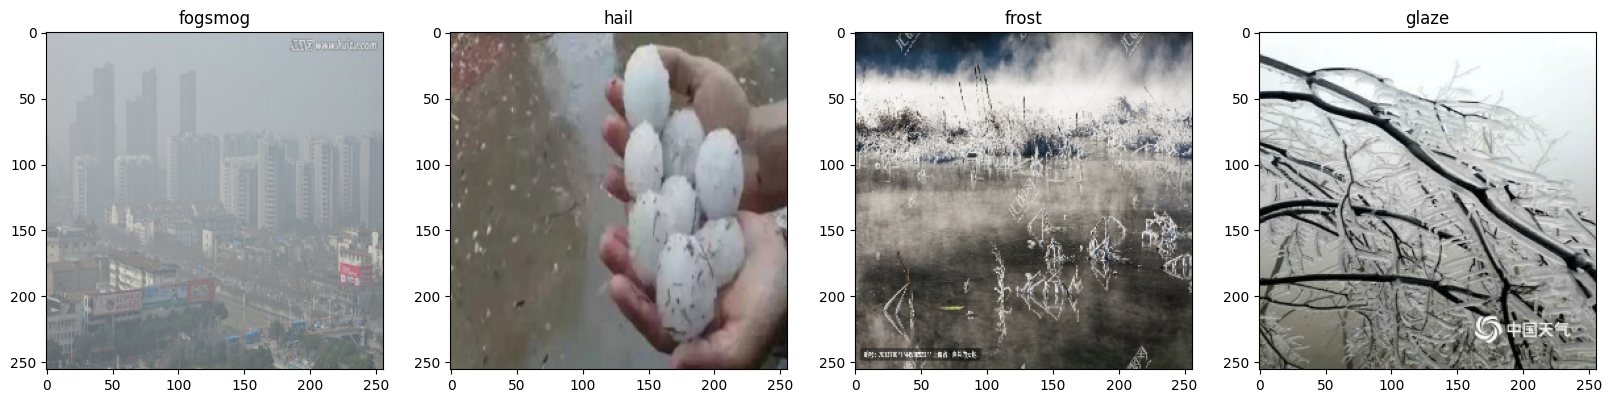

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) # plotting images
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(label[batch[1][idx]])  # we will get different plot for different batches

In [22]:
print(batch[0].min(), batch[0].max())

0.0 255.0


# **4. Scaling Data**

1.   Normalizing the pixel values(0-255) to (0-1)  to reduce computation cost.
2.   Automate this process



### 4.1 Scaling our dataset

In [23]:
data = data.map(lambda x,y: (x/255,y)) # scaling pixels, leaving y as it is

In [24]:
data.as_numpy_iterator().next()

(array([[[[7.08148718e-01, 6.56356454e-01, 6.83807433e-01],
          [7.11641788e-01, 6.58629417e-01, 6.85758710e-01],
          [6.59723818e-01, 5.91984808e-01, 6.15514219e-01],
          ...,
          [6.61806524e-01, 4.93179083e-01, 4.65783596e-01],
          [7.05277920e-01, 5.32678008e-01, 4.99145150e-01],
          [7.24517465e-01, 5.51957309e-01, 5.16696513e-01]],
 
         [[7.14140415e-01, 6.52881205e-01, 6.81550026e-01],
          [7.39719748e-01, 6.77817166e-01, 7.06064463e-01],
          [6.93055749e-01, 6.22881114e-01, 6.46577001e-01],
          ...,
          [6.45547926e-01, 4.74484831e-01, 4.50172156e-01],
          [6.65800810e-01, 4.86420035e-01, 4.65004593e-01],
          [6.89332604e-01, 5.13022840e-01, 4.81670618e-01]],
 
         [[6.60573125e-01, 5.87817311e-01, 6.21219575e-01],
          [7.60290623e-01, 6.87057972e-01, 7.19816864e-01],
          [7.88576424e-01, 7.08934903e-01, 7.34475195e-01],
          ...,
          [6.56161070e-01, 4.77660745e-01, 4.6871

In [25]:
print(data.as_numpy_iterator().next()[0].min(), data.as_numpy_iterator().next()[0].max()) #scaled between 0-1

0.0 1.0


# 5. Splitting Data


In [26]:
len(data) # no. of batches , size of 32, few images will be truncated

212

In [27]:
train_size = int(len(data)*.7) # 70% of batches present in data
val_size = int(len(data)*.2)   # 20% of batches present in data
test_size = int(len(data)*.1)  # 10% of batches present in data

In [28]:
train_size + val_size + test_size

211

In [29]:
train = data.take(train_size)                           # taking batches from 0 to train_size
val = data.skip(train_size).take(val_size)              # skipping train_size batches and taking next batch of val_size
test = data.skip(train_size+val_size).take(test_size)   # similar to above

# 6. Deep Model

In [30]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


In [44]:
model = Sequential()

In [45]:
# Adjust this according to your dataset shape
model.add(Conv2D(64, (3,3), activation='relu',padding='same', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3,3), 1,padding='same',  activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3,3), 1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3,3), 1,padding='same',  activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))  # Regularization

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(units = 11, activation='softmax'))


In [46]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,098,891 (130.08 MB)

 Trainable params: 34,097,867 (130.07 MB)

 Non-trainable params: 1,024 (4.00 KB)

# 7. Train

In [48]:
logdir='logs'

In [49]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [50]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.3356 - loss: 15.7668 - val_accuracy: 0.1868 - val_loss: 7.2029
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 253ms/step - accuracy: 0.3660 - loss: 2.1826 - val_accuracy: 0.1845 - val_loss: 6.1508
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 252ms/step - accuracy: 0.4564 - loss: 1.7043 - val_accuracy: 0.3601 - val_loss: 2.7762
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.4844 - loss: 1.5934 - val_accuracy: 0.5766 - val_loss: 1.3181
Epoch 5/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 213ms/step - accuracy: 0.5338 - loss: 1.4200 - val_accuracy: 0.5179 - val_loss: 1.5588
Epoch 6/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 252ms/step - accuracy: 0.5610 - loss: 1.3186 - val_accuracy: 0.5179 - val_loss: 1.4685
Epoch 7/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 251ms/step - accuracy: 0.5751 - loss: 1.2751 - val_accuracy: 0.6243 - val_loss: 1.1968
Epoch 8/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.5739 - loss: 

In [51]:
# Save the model in HDF5 format
model.save('my_model.h5')

# Or save it in the TensorFlow SavedModel format
# tf.keras.models.save_model(model, 'my_model')


In [52]:
from google.colab import files

# Download the model file
files.download('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
# # Zip the model directory to download
# !zip -r my_model.zip my_model
# files.download('my_model.zip')


In [54]:
model.save('after_92_acc_weather_classification.keras')

# 9. Evaluate model


In [55]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


InvalidArgumentError: {{function_node __wrapped__LogicalAnd_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:LogicalAnd] name: 

In [ ]:
print(pre.result(), re.result(), acc.result())

# 10. Test

In [56]:
import cv2

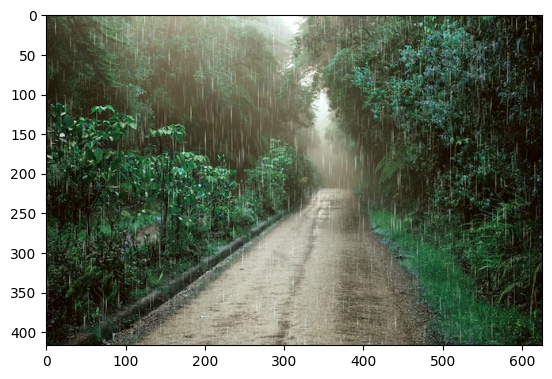

In [68]:
img = cv2.imread('weather-effects-composition_23-2149853295.jpg')
plt.imshow(img)
plt.show()

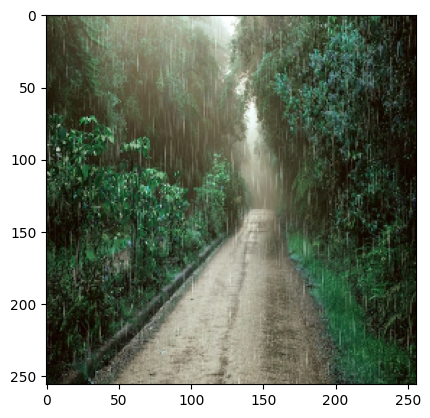

In [69]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [70]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[5.0734310e-05, 5.5120882e-08, 5.5040829e-08, 5.3851923e-04,
        1.7351704e-02, 3.3520797e-07, 9.8205858e-01, 3.2174985e-11,
        6.6904047e-09, 1.0669803e-12, 4.6403425e-08]], dtype=float32)

In [71]:
label[yhat.argmax()]



'rain'